This is a follow-up to the Dec-2021 [Archery puzzle from 538 riddler](https://fivethirtyeight.com/videos/can-you-solve-this-archery-riddle/). Here is the puzzle in detail:

<blockquote>
You are competing against your archnemesis in an archery tournament. Each contestant gets 3 shots. Shots get points. A contestant's scores is the sum of points from the individual shots. High scores are better. If the scores are equal, then the game restarts with 3 new shots. This continues till there is a winner.

There are 2 bows. One bow always causes a shot with 8 point. Another bow scores {10,9,5} with equals probability. You have to pick a bow, the other one goes to your opponent.
    
Which bow should you pick to give you a better chance at winning?
</blockquote>

Here is an example:
* Say you pick Bow1, then your score will always be $24 = 3\times8$, since there is no difference of points in each shot and there are 3 shots and each shot gets you 8 points.
* However if you pick Bow2, then each of the 3 shots can result in any point in {10,9,5} with equal probability. So with Bow2, you can get a score of $30=10+10+10$ with a probability of $\left(\frac{1}{3}\right)^3$

In [1]:
import sys
from collections import namedtuple, Counter
from itertools import product, starmap, combinations_with_replacement
import networkx as nx
# import pydot
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import partial
# from typing import Tuple, NamedTuple

In [2]:
print("sys.version | ", sys.version.replace("\n"," | "))
print("mpl.__version__ | ", mpl.__version__)
print("nx.__version__ | ", nx.__version__)

sys.version |  3.8.5 (default, Sep  4 2020, 02:22:02)  | [Clang 10.0.0 ]
mpl.__version__ |  3.3.2
nx.__version__ |  2.5


---

First lets define a class `Bow`. Each instance represesents a probability distribution over outcomes (points). Then using that we will generate all possible scores in a game of `numShot` shots. Using the scores we can compare 2 bows; `bow1` is better than `bow2` if in a competition between the two, the probability of `bow1`'s win is more than probability of its loss.

In [3]:
class Bow:
    """A Bow is a sorted list of equally likely outcomes.
    The _sorted_ part ensures that permutations of outcomes
    result in the same bow.
    """
    def __init__(self, outcomes):
        self.__outcomes = sorted(outcomes)
    
    @property
    def outcomes(self):
        return self.__outcomes

    def __str__(self):
        return '{' + ','.join(map(str,self.__outcomes)) + '}'
    
    __repr__ = __str__

# Bow = namedtuple('Bow','outcomes')
# Bow(outcomes=(5,9,10))
# Bow(outcomes=(8))

In [4]:
def allScores(bow: Bow, numShot=3):
    """Returns an iterator of all possible scores. This does
    not do any deduplication of scores.
    """
    outcome_space = [bow.outcomes for _ in range(numShot)]
    return map(sum,product(*outcome_space))

# b = Bow(outcomes=(5,9,10))
# list(allScores(b,3))

In [5]:
def LEG(x,y):
    if x<y:
        return 'L'
    elif x==y:
        return 'E'
    elif x>y:
        return 'G'
    else:
        return None

# c = Counter(starmap(LEG,product(allScores(Bow(outcomes=(5,9,10))),allScores(Bow(outcomes=tuple((8,)))))))
# print(c)
# print(c['G'] > c['L'])
# print(c['G'] < c['L'])

In [6]:
def isBetter(bow1: Bow, bow2: Bow, numShot):
    """Is _bow1_ better than _bow2_ when shot _numShot_ times"""
    bow1Scores = allScores(bow1, numShot=numShot)
    bow2Scores = allScores(bow2, numShot=numShot)
    c = Counter(starmap(LEG,product(bow1Scores,bow2Scores)))
    return c['G'] > c['L']

Lets check the bows in the puzzle, `{8}` vs `{5,9,10}`

In [7]:
bow1 = Bow(outcomes=[8])       # this is the original bow from the riddle, scores 8 everytime
bow2 = Bow(outcomes=(5,9,10))  # this is the alaternate bow which is equally likely to hit {5,9,10}
print(f"{bow1} > {bow2}" if isBetter(bow1,bow2,3) else f"{bow2} > {bow1}")

{5,9,10} > {8}


So what can be a good heuristic to determine a bow better than another without this extensive operations?

In [8]:
bow3 = Bow(outcomes=(1,2,21))  # this is the bow Arghya provided as a counterexample to a heuristic
print(f"{bow3} > {bow1}" if isBetter(bow3,bow1,3) else f"{bow1} > {bow3}")
print(f"{bow3} > {bow2}" if isBetter(bow3,bow2,3) else f"{bow2} > {bow3}")

{8} > {1,2,21}
{5,9,10} > {1,2,21}


---

Instead of trying to guess a good bow. Lets generate all possible bows with a given expected score. Then we can induce a graph with the bows as nodes, and `isBetter` as edge. If this is a DAG, we can do a topological sort and get the relative _preference_ of bows. If we are lucky there might exist a _best_ and _worst_ bow as well.

For simplicity, I am limiting the set of bows to the ones with same number of outcomes to avoid the powerset enumeration.

For the set of bows , the free parameters are:
1. `expScore` the expected score from each bow; by definition they will be same across all bows
2. `numOutcome` number of equally likely outcomes from each bow; by definition they will be same across all bows

Then for the graph, there are following free parameters:
1. `numShot` number of shots allowed
2. `bows` a set of bows

In [9]:
def generateBows(expScore: int, numOutcome: int):
    return [
        Bow(outcomes=e)
        for e in combinations_with_replacement(range(1,expScore-numOutcome+1),numOutcome)
        if sum(e)==expScore]

In [10]:
def induceDiGraph(bows, numShot):
    g = nx.DiGraph()
    g.add_nodes_from(bows)

    for b1,b2 in product(bows,bows):
        if isBetter(b1,b2,numShot):
            g.add_edge(b1,b2)
    
    return g

In [11]:
def printCycles(graph):
    cycles = list(nx.simple_cycles(graph))
    print(f"{len(cycles)} cycles found")
    
    for cycle in cycles:
        print(cycle)

        pos = nx.circular_layout(graph)
        subGraph = graph.subgraph(cycle)
        options = {
            'node_color': 'white',
            'node_size': 300,
            'font_size': 16,
            'with_labels': True,
        }
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        nx.draw_networkx(graph,pos=pos,**options,alpha=0.1) #, node_color="tab:blue", **options)
        nx.draw_networkx(subGraph,pos=pos,**options) #, node_color="tab:blue", **options)
        plt.box(False)
        plt.show()

In [12]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='circo'))
#     return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

# g1 = """digraph top {
#    a -> b -> c;
# }"""
# draw(g1)

def printCyclesDot(graph):
    cycles = list(nx.simple_cycles(graph))
    print(f"{len(cycles)} cycles found")
    
    for cycle in cycles:
        print(cycle)
        subGraph = graph15.subgraph(cycle)
        ag = nx.nx_agraph.to_agraph(subGraph)
        display(draw(ag.to_string()))
    #     break;

In [13]:
def showAndAnalyzeGraph(numShot, numOutcome, expScore):
    bows = generateBows(expScore, numOutcome)
    graph = induceDiGraph(bows, numShot)

    options = {
        'node_color': 'white',
        'edge_color': 'gray',
        'node_size': 300,
        'font_size': 16,
        'with_labels': True,
    }
    if len(graph.nodes)<=30:
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        nx.draw_circular(graph,**options) #with_labels=True,node_color="tab:blue")
        plt.box(False)
        plt.show()
    else:
        print(f"Not printing large graph with {len(graph.nodes)} nodes")

    cycles = list(nx.simple_cycles(graph))
    if len(cycles) == 0:
        print('DAG')
        print(list(nx.topological_sort(graph)))
    else:
        print('Cycles detected')
    #     print(cycles)
        cycles = list(nx.simple_cycles(graph))
        for cycle in cycles:
            print(cycle)
#             printCycles(graph, cycle)
    
    return graph

### numShot=3, numOutcome=3, expScore=12

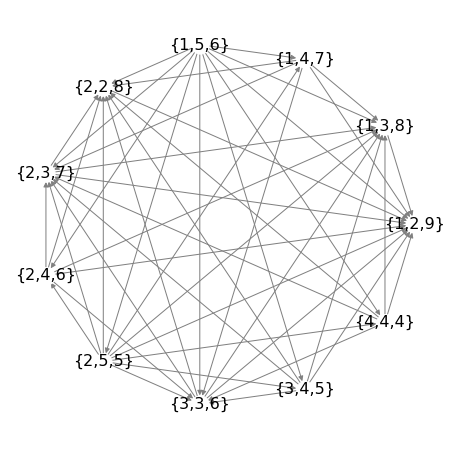

DAG
[{1,5,6}, {2,5,5}, {4,4,4}, {3,4,5}, {2,4,6}, {1,4,7}, {3,3,6}, {2,3,7}, {2,2,8}, {1,3,8}, {1,2,9}]


In [14]:
graph12 = showAndAnalyzeGraph(numShot=3,numOutcome=3,expScore=12)

### numShot=3, numOutcome=3, expScore=15

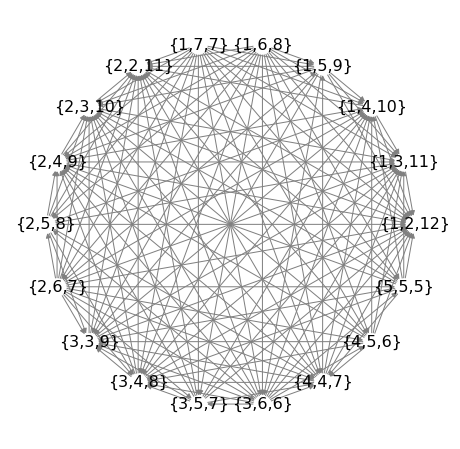

Cycles detected
[{4,4,7}, {1,5,9}, {3,6,6}, {5,5,5}]
[{4,4,7}, {1,5,9}, {3,6,6}, {4,5,6}]
[{4,4,7}, {1,5,9}, {3,6,6}]
[{4,4,7}, {1,5,9}, {3,6,6}, {3,5,7}]
[{4,4,7}, {1,5,9}, {3,6,6}, {2,5,8}]


In [15]:
graph15 = showAndAnalyzeGraph(numShot=3,numOutcome=3,expScore=15)

5 cycles found
[{4,4,7}, {1,5,9}, {3,6,6}, {5,5,5}]


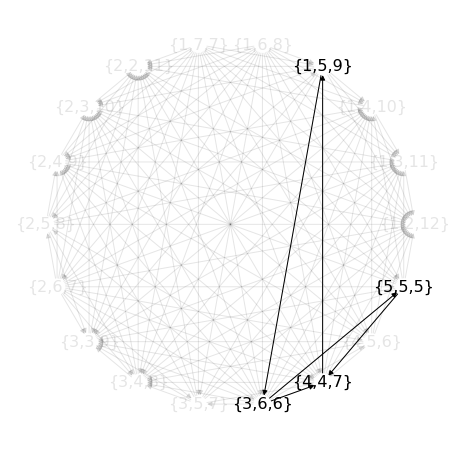

[{4,4,7}, {1,5,9}, {3,6,6}, {4,5,6}]


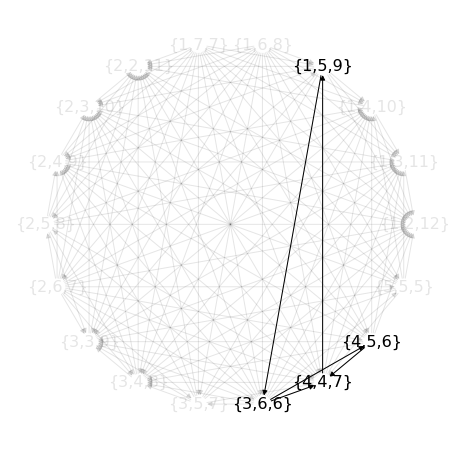

[{4,4,7}, {1,5,9}, {3,6,6}]


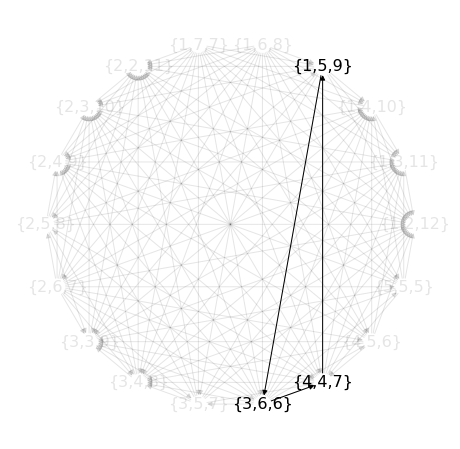

[{4,4,7}, {1,5,9}, {3,6,6}, {3,5,7}]


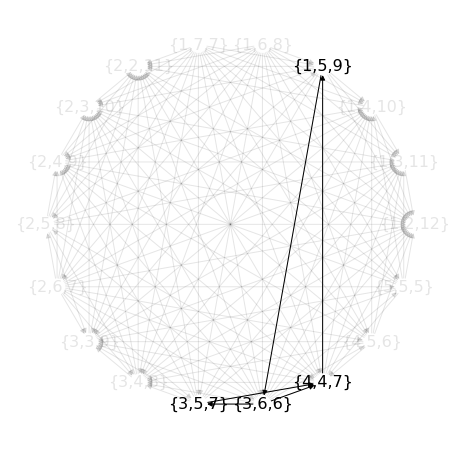

[{4,4,7}, {1,5,9}, {3,6,6}, {2,5,8}]


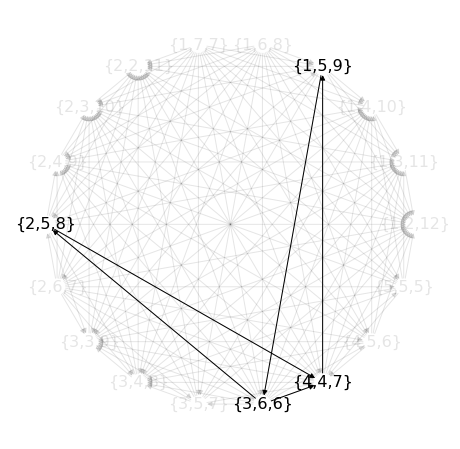

In [16]:
printCycles(graph15)

5 cycles found
[{4,4,7}, {1,5,9}, {3,6,6}, {5,5,5}]


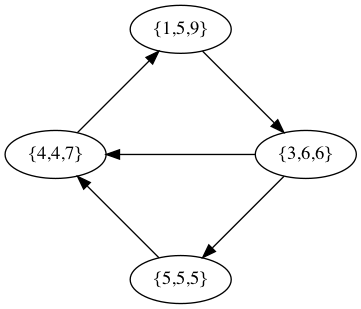

[{4,4,7}, {1,5,9}, {3,6,6}, {4,5,6}]


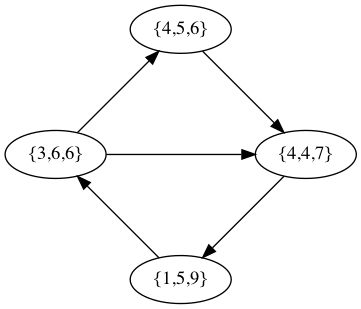

[{4,4,7}, {1,5,9}, {3,6,6}]


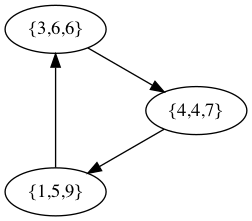

[{4,4,7}, {1,5,9}, {3,6,6}, {3,5,7}]


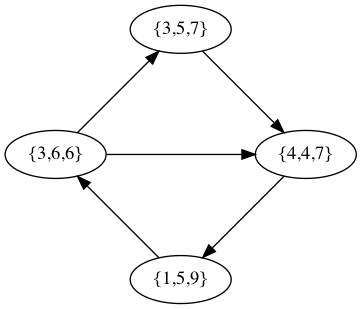

[{4,4,7}, {1,5,9}, {3,6,6}, {2,5,8}]


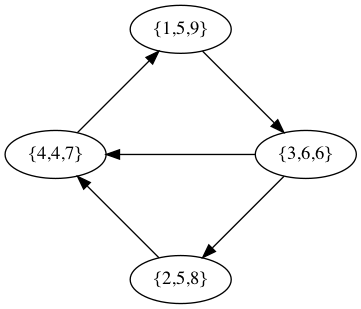

In [17]:
printCyclesDot(graph15)

---

### Random snippets to visualize graphs

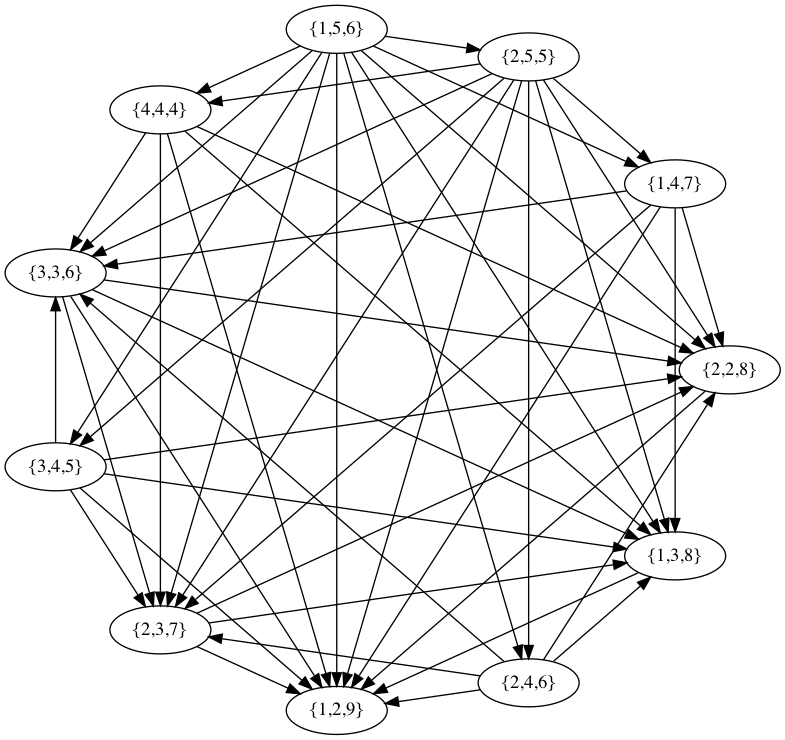

In [19]:
draw(nx.nx_agraph.to_agraph(graph12).to_string())